In [37]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score





from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def get_data(ticker, start_date='2018-01-01', end_date='2025-07-15', save_csv=False):
    os.makedirs("data", exist_ok=True)
    filename = f"data/{ticker.lower()}.csv"
    # if os.path.exists(filename):
    #     print(f"Data for {i} already exists, skipping download.")
    #     continue

    data = yf.download(ticker.upper(), start=start_date, end=end_date, auto_adjust=True)

    # Handle empty or failed download
    if data.empty:
        print(f"No data found for {ticker}")
        return pd.DataFrame()
    
    # Flatten column headers if it's a MultiIndex (e.g., from group_by='ticker')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data.reset_index(inplace=True)
    data['Ticker'] = ticker.lower()
    data['Date'] = pd.to_datetime(data['Date'])
    data.columns = [col.lower() for col in data.columns]


    if save_csv:
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    return data

In [3]:
# targets: PLTR, SPOT, XOM

tickers = ['pltr', 'spot', 'xom']
dfs = {i: None for i in tickers}
start_dates = {
    'pltr': '2020-09-30',
    'spot': '2018-04-03',
    'xom': '2018-01-01'  # only going to use data from 2018 onwards
}

for i in tickers:
    dfs[i] = get_data(i, start_date=start_dates.get(i, '2018-01-01'), save_csv=True)

[*********************100%***********************]  1 of 1 completed


Saved data for pltr to data/pltr.csv


[*********************100%***********************]  1 of 1 completed


Saved data for spot to data/spot.csv


[*********************100%***********************]  1 of 1 completed

Saved data for xom to data/xom.csv


In [4]:
for idx, i in dfs.items():
    print(f"{idx.upper()} shape: {i.shape}")

PLTR shape: (1201, 7)
SPOT shape: (1830, 7)
XOM shape: (1892, 7)


In [5]:
pd.concat([dfs['pltr'].head(), dfs['pltr'].tail()])

,date,close,high,low,open,volume,ticker
0,2020-09-30,9.500000,11.410000,9.110000,10.000000,338584400,pltr
1,2020-10-01,9.460000,10.100000,9.230000,9.690000,124297600,pltr
2,2020-10-02,9.200000,9.280000,8.940000,9.060000,55018300,pltr
3,2020-10-05,9.030000,9.490000,8.920000,9.430000,36316900,pltr
4,2020-10-06,9.900000,10.180000,8.900000,9.040000,90864000,pltr
1196,2025-07-08,139.710007,139.854996,135.789993,138.774994,59834800,pltr
1197,2025-07-09,143.130005,143.169998,137.389999,139.654999,68494800,pltr
1198,2025-07-10,142.500000,145.160004,139.529999,143.309998,64383900,pltr
1199,2025-07-11,142.100006,144.580002,141.470001,142.110001,52134800,pltr
1200,2025-07-14,149.149994,149.574997,142.220001,142.720001,81774400,pltr


In [6]:
# macro tickers
tickers_macro = ['spy', 'qqq', '^vix', 'cl=f', '^tnx']
dfs_macro = {i: None for i in tickers_macro}
for i in tickers_macro:
    dfs_macro[i] = get_data(i, save_csv=True)

[*********************100%***********************]  1 of 1 completed


Saved data for spy to data/spy.csv


[*********************100%***********************]  1 of 1 completed


Saved data for qqq to data/qqq.csv


[*********************100%***********************]  1 of 1 completed


Saved data for ^vix to data/^vix.csv


[*********************100%***********************]  1 of 1 completed


Saved data for cl=f to data/cl=f.csv


[*********************100%***********************]  1 of 1 completed

Saved data for ^tnx to data/^tnx.csv


In [7]:
for idx, i in dfs_macro.items():
    print(f"{idx.upper()} shape: {i.shape}")

SPY shape: (1892, 7)
QQQ shape: (1892, 7)
^VIX shape: (1892, 7)
CL=F shape: (1894, 7)
^TNX shape: (1892, 7)


In [8]:
pd.concat([dfs_macro['spy'].head(), dfs_macro['spy'].tail()])

,date,close,high,low,open,volume,ticker
0,2018-01-02,238.568771,238.604284,237.352720,237.743280,86655700,spy
1,2018-01-03,240.077744,240.228653,238.737411,238.737411,90070400,spy
2,2018-01-04,241.089600,241.577813,240.139854,240.725695,80636400,spy
3,2018-01-05,242.696213,242.820467,241.391393,241.888465,83524000,spy
4,2018-01-08,243.140091,243.299858,242.305715,242.598622,57319200,spy
1887,2025-07-08,620.340027,622.109985,619.520020,621.349976,59024600,spy
1888,2025-07-09,624.059998,624.719971,620.909973,622.770020,66113300,spy
1889,2025-07-10,625.820007,626.869995,623.010010,624.200012,57529000,spy
1890,2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,spy
1891,2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,spy


# from the assingments 

In [9]:
import warnings
warnings.simplefilter('ignore')


import fAux
import mc_permutation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
from sklearn import preprocessing
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
import ta
from ta.trend import EMAIndicator 
import detrendPrice 
global global_returns
global global_labels

np.random.seed(2) #to fix the results
rs = 2

def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    https://stackoverflow.com/questions/36522220/searching-a-sequence-in-a-numpy-array
    https://archive.is/GBCln
    """
    
    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found



def mean_return(y_true, y_pred):
    #this function has access to two global variables (global_labels and global_returns)
    #to help in the calculation of the model returns (multiplying mkt returns by positions derived from y_pred)
    #search_sequence_numpy searches for the index ix of the global_labels that correspond to the sequence of true lables (y_true)
    #those ix are then used to obtain the mkt returns that need to be multiplied by the positions to obtain the model returns

    ix = search_sequence_numpy(global_labels.values.flatten(), y_true) 
    mkt_returns = global_returns.values[ix] # alternative to global_returns.values[ix[0]:ix[0]+y_true.size]
    mkt_returns = mkt_returns.flatten()
    
    positions = np.where(y_pred> 0,1,-1 )
    positions = np.nan_to_num(positions, nan=0.0)
    dailyRet = positions * mkt_returns
    dailyRet = np.nan_to_num(dailyRet, nan=0.0)
    
    #val_model_returns.append(dailyRet)
    #mean_return = gmean(dailyRet+1)-1 #will use log returns instead beause...
    dailyRet = np.log(dailyRet+1)
    mean_return = np.mean(dailyRet) #GridSearchCV and RandomSearchCV use arithmetic mean
    return mean_return

def profit_ratio(y_true, y_pred):
    
    ix = search_sequence_numpy(global_labels.values.flatten(), y_true) 
    mkt_returns = global_returns.values[ix] # alternative to global_returns.values[ix[0]:ix[0]+y_true.size]
    mkt_returns = mkt_returns.flatten()
    
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * mkt_returns #calculate the daily returns of the system
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    profits = np.where((dailyRet_arr >= 0), dailyRet_arr, 0)
    losses = np.where((dailyRet_arr < 0), dailyRet_arr, 0)
    profit_ratio = np.sum(profits)/np.sum(np.abs(losses))
    return profit_ratio


def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#PANDAS exponential smoothing:
def pandas_ewm_smoother(x_train, span=None):
    x_train = pd.DataFrame(x_train)
    x_train_smooth = x_train.ewm(span=span, adjust=True).mean()
    return  x_train_smooth.values

#Ta-lib exponential smoothing:
def talib_ewm_smoother(x_train, span=None):
    w = np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[1]):
        # a = ta.EMA(x_train[:,i], timeperiod=span)
        a = EMAIndicator(close=x_train[:,i], window=span).ema_indicator().values
        w = np.c_[w,a]
    return w[:,1:]

myscorer = None #use default accuracy score
#myscorer = make_scorer(mean_return, greater_is_better=True)
#myscorer = make_scorer(profit_ratio, greater_is_better=True)
#myscorer = make_scorer(phi_k, greater_is_better=True)

#when using smoother, use TimesSeriesSplit
n_splits = 5
#split = 5 
#split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
split = TimeSeriesSplit(n_splits=n_splits)


#smoother = FunctionTransformer(talib_ewm_smoother)
smoother = FunctionTransformer(pandas_ewm_smoother)

# SPOT

## some ideas:
1. (most simple) will it close higher tmrw? -> binary classification (logistic reg, random forest, xgb)
2. what would the return be like over the next three days -> regression
3. will it outperform the s&p500 over the next five days
4. predict price direction after earning reports (may also introduce several other companies & their earning report dates and performance)


## brainstorm
- explicitly define the time horizon upfront
    - let's start off with: Swing Trading 
        - hodling period: days to weeks 
        - taraget example: return in 1-10 dyas 
        - suitable features: daily candles, TA indicators, moving average 
## pipeline and steps for swing trading using SPOT:
0. define the objective (e.g., predict if SPOT will rise in the next N days (e.g., 5-day return > 1%))
    - swing trading: holding 3-10 days
    - trade at opening (no intra day trading yet-advanced)
    - data: daily OHLCV + engineered TA features 
    - model type: binary classifier (0: no trade, 1: go long)
1. load and preprocess data
    - SPOT daily OHLCV
2. feature engineering (technical indicators)
    - trend: returns, SMA (10/50/200), EMA slope
    - momentum: RSI(14), MACD, stochastics 
    - volatility: ATR, bollinger band width
    - candle patterns: bullish/bearish engulfing, hammer, etc.
    - support/resistance proximity (optional)
3. define target variable   
    e.g.   
    `df['future_return_5d'] = (df['close'].shift(-5) - df['close']) / df['close']`  
    `df['target'] = (df['future_return_5d'] > 0.01).astype(int)`  
4. split train/test and normalize 
5. train ML model
6. predict & evaluate 
7. backtest
8. white reality check & monte carlo simulation 

### other consideration
- 1 stock or many stock? 
    - 1 stock -> proof of concept; quick iteration and backtesting; model learns idiosyncratic behaviour 
    - multiple stocks -> robustness across different assets; training on more diverse patterns; generalization to unseen assets; use ticker as a caotegorical features (optional)

In [10]:
spotdf = dfs['spot']
print(spotdf.shape)
pd.concat([spotdf.head(), spotdf.tail()])

(1830, 7)


,date,close,high,low,open,volume,ticker
0,2018-04-03,149.009995,169.000000,148.259995,165.899994,30526500,spot
1,2018-04-04,144.220001,148.929993,135.509995,140.000000,11702900,spot
2,2018-04-05,143.990005,152.410004,141.250000,149.229996,7372800,spot
3,2018-04-06,147.919998,148.729996,144.669998,146.070007,4228100,spot
4,2018-04-09,150.000000,151.000000,148.589996,149.500000,2051400,spot
1825,2025-07-08,721.390015,743.989990,709.989990,738.450012,1774500,spot
1826,2025-07-09,722.119995,731.979980,713.500000,722.440002,1362400,spot
1827,2025-07-10,709.950012,726.823975,699.000000,720.570007,1337800,spot
1828,2025-07-11,709.150024,714.099976,699.825012,709.000000,1267500,spot
1829,2025-07-14,717.489990,723.869995,707.150024,711.890015,1256700,spot


In [11]:
spotdf = dfs['spot'].copy()

# Data preparation 
spotdf['date'] = pd.to_datetime(spotdf['date'])
spotdf['month'] = spotdf['date'].dt.month
spotdf['dayofweek'] = spotdf['date'].dt.dayofweek
# You can drop 'date' after this if not needed

# save the close and open for white reality check
openp = spotdf['open'].copy() #for the case we want to enter trades at the open
closep = spotdf['close'].copy() #for the case we want to enter trades at the close

# Feature engineering with original data
# build the best window features after the exploratory data analysis:
for n in list(range(1,21)):
    name = 'ret' + str(n)
    spotdf[name] = spotdf["open"].pct_change(periods=n) #for trading with open
    #spotdf[name] = spotdf["close"].pct_change(periods=n) #for trading with close

#build target assuming we know today's open
spotdf['retFut1'] = spotdf['open'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#spotdf['retFut1'] = spotdf['close'].pct_change(1).shift(-1) #if you wait until the close to enter the trade
# spotdf = np.log(spotdf+1)

#transform the target
spotdf['retFut1_categ'] = np.where((spotdf['retFut1'] > 0), 1, 0)

# Since we are trading right after the open, 
# we only know yesterday's  high low close volume etc.
spotdf['high'] = spotdf['high'].shift(1)
spotdf['low'] = spotdf['low'].shift(1)
spotdf['close'] = spotdf['close'].shift(1)
spotdf['volume'] = spotdf['volume'].shift(1)
# spotdf['<SPREAD>'] = spotdf['<SPREAD>'].shift(1)

#select the features (by dropping)
# cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
# df_filtered = df.drop(cols_to_drop, axis=1)

print(spotdf.shape)

(1830, 31)


In [12]:
# add more technical features

# 1. trend features 
# Simple Moving Averages (10, 50, 200)
spotdf['sma10'] = spotdf['close'].rolling(10).mean()
spotdf['sma50'] = spotdf['close'].rolling(50).mean()
spotdf['sma200'] = spotdf['close'].rolling(200).mean()

# Exponential Moving Average Slope
ema = spotdf['close'].ewm(span=20, adjust=False).mean()
spotdf['ema_slope'] = ema.diff()


# 2. momentum features
# RSI (14)
spotdf['rsi'] = ta.momentum.RSIIndicator(close=spotdf['close'], window=14).rsi()

# MACD
macd = ta.trend.MACD(close=spotdf['close'])
spotdf['macd'] = macd.macd()
spotdf['macd_signal'] = macd.macd_signal()

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=spotdf['high'], low=spotdf['low'], close=spotdf['close'])
spotdf['stoch_k'] = stoch.stoch()
spotdf['stoch_d'] = stoch.stoch_signal()


# 3. volatility features
# ATR (Average True Range)
atr = ta.volatility.AverageTrueRange(high=spotdf['high'], low=spotdf['low'], close=spotdf['close'])
spotdf['atr'] = atr.average_true_range()

# Bollinger Band Width
bb = ta.volatility.BollingerBands(close=spotdf['close'], window=20, window_dev=2)
spotdf['bb_width'] = bb.bollinger_wband()


# 4. candle patterns
# bullish engulfing pattern
# Yesterday's open/close
o1 = spotdf['open'].shift(1)
c1 = spotdf['close'].shift(1)

# Today's open/close
o2 = spotdf['open']
c2 = spotdf['close']

# Bullish engulfing condition
spotdf['bull_engulf'] = (c1 < o1) & (c2 > o2) & (c2 > o1) & (o2 < c1)

In [13]:
print(f'original shape: {spotdf.shape}')

spotdf.dropna(inplace=True) #drop rows with NaN values
print(f'shape after dropping NaN values: {spotdf.shape}')
spotdf.head()

original shape: (1830, 43)
shape after dropping NaN values: (1630, 43)


,date,close,high,low,open,volume,ticker,month,dayofweek,ret1,...,sma200,ema_slope,rsi,macd,macd_signal,stoch_k,stoch_d,atr,bb_width,bull_engulf
200,2019-01-17,134.250000,134.559998,130.149994,133.020004,2152200.0,spot,1,3,0.007575,...,158.863801,1.211560,62.172847,0.178948,-2.753112,98.806324,96.341159,6.807334,24.168691,False
201,2019-01-18,133.250000,135.350006,132.529999,135.000000,1372400.0,spot,1,4,0.014885,...,158.785001,1.000935,60.781419,0.934223,-2.015645,92.152446,95.465495,6.522525,26.503931,False
202,2019-01-22,133.660004,136.000000,132.580002,132.610001,1314100.0,spot,1,1,-0.017704,...,158.732201,0.944656,61.165174,1.548022,-1.302911,91.462984,94.140585,6.300916,28.543147,False
203,2019-01-23,133.800003,134.770004,131.759995,134.199997,1255600.0,spot,1,2,0.011990,...,158.681251,0.868022,61.304408,2.022447,-0.637840,91.973744,91.863058,6.065852,29.899835,False
204,2019-01-24,130.919998,135.500000,128.535004,131.000000,1159400.0,spot,1,3,-0.023845,...,158.596251,0.511067,56.793387,2.141355,-0.082001,81.466614,88.301114,6.130076,28.692342,False


In [14]:
X = spotdf.drop(columns=['date', 'retFut1', 'retFut1_categ', 'ticker'])  # or keep 'date' if needed
y = spotdf['retFut1_categ']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# check
assert not X_train.isnull().any().any()
assert np.isfinite(X_train).all().all()


In [16]:
# baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'class distribution in y_train: {y_train.value_counts(normalize=True)}')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

class distribution in y_train: retFut1_categ
1    0.517638
0    0.482362
Name: proportion, dtype: float64
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       152
           1       0.59      0.35      0.44       174

    accuracy                           0.52       326
   macro avg       0.54      0.53      0.51       326
weighted avg       0.54      0.52      0.51       326

Accuracy: 0.5214723926380368
[[109  43]
 [113  61]]


<Axes: >

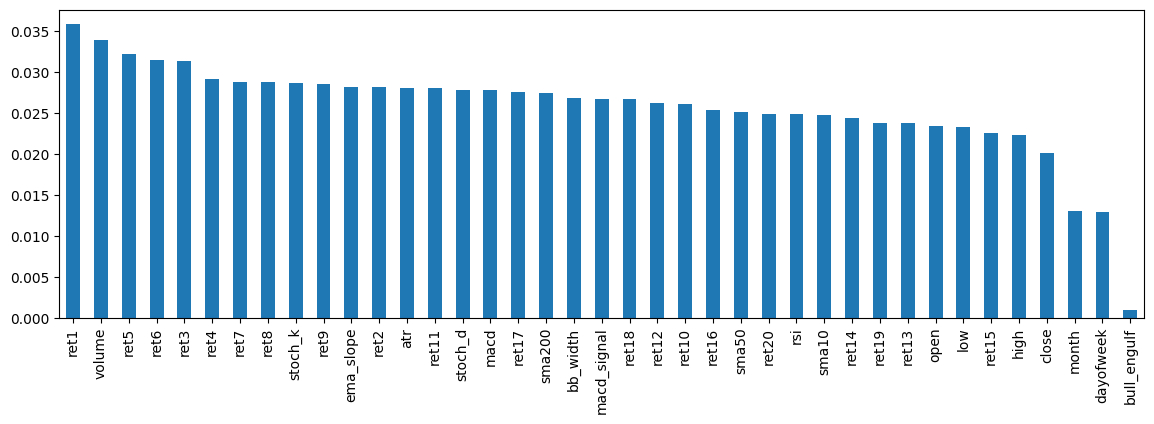

In [17]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(14, 4))

In [18]:
# xgb
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
print(classification_report(y_test, xgb.predict(X_test)))


              precision    recall  f1-score   support

           0       0.52      0.64      0.57       152
           1       0.60      0.48      0.54       174

    accuracy                           0.56       326
   macro avg       0.56      0.56      0.55       326
weighted avg       0.56      0.56      0.55       326



In [19]:
# check correlation between features and target
for i in X.columns:
    print(f'Correlation between {i} and retFut1_categ: {spotdf[i].corr(spotdf["retFut1_categ"])}')


Correlation between close and retFut1_categ: -0.0029315352279383994
Correlation between high and retFut1_categ: -0.0026893165052723758
Correlation between low and retFut1_categ: -0.0018288876060090545
Correlation between open and retFut1_categ: -0.004322923811070118
Correlation between volume and retFut1_categ: 0.003556406598646816
Correlation between month and retFut1_categ: -0.02104331357593899
Correlation between dayofweek and retFut1_categ: -0.016499362317288085
Correlation between ret1 and retFut1_categ: -0.04920881229612368
Correlation between ret2 and retFut1_categ: -0.028709464097196505
Correlation between ret3 and retFut1_categ: -0.034325636612794946
Correlation between ret4 and retFut1_categ: -0.025013894013894315
Correlation between ret5 and retFut1_categ: -0.045391318837975675
Correlation between ret6 and retFut1_categ: -0.03449051680305724
Correlation between ret7 and retFut1_categ: -0.024856747803968564
Correlation between ret8 and retFut1_categ: -0.010856174306639408
Cor

# above: bad as fuck!

In [20]:
spotlstmdf = dfs['spot'].copy()
spotlstmdf.drop(columns=['ticker'], inplace=True)  

# Data preparation 
spotlstmdf['date'] = pd.to_datetime(spotlstmdf['date'])
spotlstmdf['month'] = spotlstmdf['date'].dt.month
spotlstmdf['dayofweek'] = spotlstmdf['date'].dt.dayofweek
# You can drop 'date' after this if not needed

# save the close and open for white reality check
openp_lstm = spotlstmdf['open'].copy() #for the case we want to enter trades at the open
closep_lstm = spotlstmdf['close'].copy() #for the case we want to enter trades at the close

# Feature engineering with original data
# build the best window features after the exploratory data analysis:
for n in list(range(1, 21)):
    name = 'ret' + str(n)
    spotlstmdf[name] = spotlstmdf['open'].pct_change(periods=n) # for trading with open

# build target assuming we know today's open
spotlstmdf['retFut1'] = spotlstmdf['open'].pct_change(1).shift(-1).fillna(0)  # if you enter the trade immediately after the open

# transform the target
spotlstmdf['retFut1_categ'] = np.where((spotlstmdf['retFut1'] > 0), 1, 0)

# Since we are trading right after the open, 
# we only know yesterday's high, low, close, volume etc.
spotlstmdf['high'] = spotlstmdf['high'].shift(1)
spotlstmdf['low'] = spotlstmdf['low'].shift(1)
spotlstmdf['close'] = spotlstmdf['close'].shift(1)
spotlstmdf['volume'] = spotlstmdf['volume'].shift(1)

# 1. trend features 
# Simple Moving Averages (10, 50, 200)
spotlstmdf['sma10'] = spotlstmdf['close'].rolling(10).mean()
spotlstmdf['sma50'] = spotlstmdf['close'].rolling(50).mean()
spotlstmdf['sma200'] = spotlstmdf['close'].rolling(200).mean()

# Exponential Moving Average Slope
ema = spotlstmdf['close'].ewm(span=20, adjust=False).mean()
spotlstmdf['ema_slope'] = ema.diff()

# ADD: % distance from SMA
spotlstmdf['pct_sma10'] = (spotlstmdf['close'] - spotlstmdf['sma10']) / spotlstmdf['sma10']

# 2. momentum features
# RSI (14)
spotlstmdf['rsi'] = ta.momentum.RSIIndicator(close=spotlstmdf['close'], window=14).rsi()

# MACD
macd = ta.trend.MACD(close=spotlstmdf['close'])
spotlstmdf['macd'] = macd.macd()
spotlstmdf['macd_signal'] = macd.macd_signal()
spotlstmdf['macd_hist'] = spotlstmdf['macd'] - spotlstmdf['macd_signal']

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=spotlstmdf['high'], low=spotlstmdf['low'], close=spotlstmdf['close'])
spotlstmdf['stoch_k'] = stoch.stoch()
spotlstmdf['stoch_d'] = stoch.stoch_signal()

# Williams %R
spotlstmdf['williams_r'] = ta.momentum.WilliamsRIndicator(high=spotlstmdf['high'], low=spotlstmdf['low'], close=spotlstmdf['close'], lbp=14).williams_r()

# 3. volatility features
# ATR (Average True Range)
atr = ta.volatility.AverageTrueRange(high=spotlstmdf['high'], low=spotlstmdf['low'], close=spotlstmdf['close'])
spotlstmdf['atr'] = atr.average_true_range()

# Bollinger Band Width
bb = ta.volatility.BollingerBands(close=spotlstmdf['close'], window=20, window_dev=2)
spotlstmdf['bb_width'] = bb.bollinger_wband()

# Rolling Volatility (standard deviation of close returns over 10 days)
spotlstmdf['roll_vol'] = spotlstmdf['close'].pct_change().rolling(10).std()

# Volume z-score
spotlstmdf['volume_z'] = (spotlstmdf['volume'] - spotlstmdf['volume'].rolling(20).mean()) / spotlstmdf['volume'].rolling(20).std()

# 4. candle patterns
# bullish engulfing pattern
# Yesterday's open/close
o1 = spotlstmdf['open'].shift(1)
c1 = spotlstmdf['close'].shift(1)

# Today's open/close
o2 = spotlstmdf['open']
c2 = spotlstmdf['close']

# Bullish engulfing condition
spotlstmdf['bull_engulf'] = (c1 < o1) & (c2 > o2) & (c2 > o1) & (o2 < c1)

# 5. contextual market features (add after merge if SPY data is loaded separately)
# e.g., spotlstmdf['spy_ret1'] = spy['close'].pct_change().shift(1)
# e.g., spotlstmdf['vix_change'] = vix['close'].pct_change().shift(1)
spydf = dfs_macro['spy'].copy()
# Ensure SPY data is aligned on date
spydf['date'] = pd.to_datetime(spydf['date'])
spydf = spydf[['date', 'close']].rename(columns={'close': 'spy_close'})

# Merge SPY with spotlstmdf on date
spotlstmdf = pd.merge(spotlstmdf, spydf, on='date', how='left')

# Create SPY features with .shift(1) to avoid leakage
spotlstmdf['spy_ret1'] = spotlstmdf['spy_close'].pct_change().shift(1)
spotlstmdf['spy_ret5'] = spotlstmdf['spy_close'].pct_change(5).shift(1)
spotlstmdf['spy_roll_vol'] = spotlstmdf['spy_close'].pct_change().rolling(10).std().shift(1)


In [21]:
spotlstmdf.columns
spotlstmdf.describe()
print(spotlstmdf.isna().sum())

date               0
close              1
high               1
low                1
open               0
volume             1
month              0
dayofweek          0
ret1               1
ret2               2
ret3               3
ret4               4
ret5               5
ret6               6
ret7               7
ret8               8
ret9               9
ret10             10
ret11             11
ret12             12
ret13             13
ret14             14
ret15             15
ret16             16
ret17             17
ret18             18
ret19             19
ret20             20
retFut1            0
retFut1_categ      0
sma10             10
sma50             50
sma200           200
ema_slope          2
pct_sma10         10
rsi               13
macd              26
macd_signal       34
macd_hist         34
stoch_k           14
stoch_d           16
williams_r        14
atr                0
bb_width          20
roll_vol          11
volume_z          20
bull_engulf        0
spy_close    

In [29]:
# check class imbalance
print(spotlstmdf['retFut1_categ'].value_counts(normalize=True))


retFut1_categ
1    0.521158
0    0.478842
Name: proportion, dtype: float64


In [22]:

# Select features for modeling (exclude date, target, openp, closep, etc.)
feature_cols = [col for col in spotlstmdf.columns if col not in ['date', 'retFut1', 'retFut1_categ', 'open', 'openp', 'closep']]

# impute sma50 and sma200
spotlstmdf['sma50'].fillna(method='ffill', inplace=True)
spotlstmdf['sma50'].fillna(method='bfill', inplace=True)

spotlstmdf['sma200'].fillna(method='ffill', inplace=True)
spotlstmdf['sma200'].fillna(method='bfill', inplace=True)

# Drop rows with missing values
spotlstmdf.dropna(subset=feature_cols + ['retFut1_categ'], inplace=True)


# Scale features
scaler = StandardScaler()
spotlstmdf[feature_cols] = scaler.fit_transform(spotlstmdf[feature_cols])


# Define lookback window (e.g., past 30 days)
window_size = 30

# Prepare sequences
X = []
y = []

for i in range(window_size, len(spotlstmdf)):
    X.append(spotlstmdf[feature_cols].iloc[i - window_size:i].values)
    y.append(spotlstmdf['retFut1_categ'].iloc[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, time_steps, features)
print("y shape:", y.shape)


# Example split: 80% train, 20% test (time-based, no shuffling)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X shape: (1766, 30, 47)
y shape: (1766,)


In [26]:
# Model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4909 - loss: 0.7063 - val_accuracy: 0.5085 - val_loss: 0.7009
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5497 - loss: 0.6835 - val_accuracy: 0.5056 - val_loss: 0.6948
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5623 - loss: 0.6834 - val_accuracy: 0.5254 - val_loss: 0.7114
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5986 - loss: 0.6702 - val_accuracy: 0.5254 - val_loss: 0.6983
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6275 - loss: 0.6599 - val_accuracy: 0.5254 - val_loss: 0.6981
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6152 - loss: 0.6650 - val_accuracy: 0.5198 - val_loss: 0.6938
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6095 - loss: 0.6629 - val_accuracy: 0.5141 - val_loss: 0.7123
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6278 - loss: 0.6497 - val_accuracy: 0.5113 - v

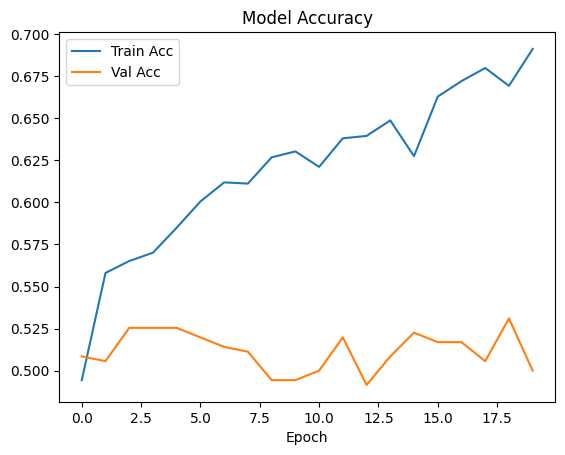

Test Accuracy: 0.5000


In [27]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

retFut1_categ
1    0.521158
0    0.478842
Name: proportion, dtype: float64


In [ ]:
# check logistic regression on flattened data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)
y_pred = lr_model.predict(X_test_flat)
acc = accuracy_score(y_test, y_pred)

print("Logistic Regression Test Accuracy:", round(acc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')


Logistic Regression Test Accuracy: 0.5706

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.46      0.49       162
           1       0.59      0.67      0.63       192

    accuracy                           0.57       354
   macro avg       0.56      0.56      0.56       354
weighted avg       0.57      0.57      0.57       354


Confusion Matrix:
 [[ 74  88]
 [ 64 128]]
accuracy score: 0.5706214689265536


In [35]:
# try the two layer version lstm
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_pred_probs = model.predict(X_test).ravel()
y_pred_labels = (y_pred_probs > 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_pred_probs))
print("Precision:", precision_score(y_test, y_pred_labels))
print("Recall:", recall_score(y_test, y_pred_labels))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
AUC: 0.5185185185185185
Precision: 0.5714285714285714
Recall: 0.2708333333333333


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


Total confident predictions (prob > 0.6): 0
No confident predictions (prob > 0.6)
